# Portfolio Theory with Matrix Algebra

This notebook demonstrates portfolio theory concepts using matrix algebra, including:
- Portfolio return and risk characteristics
- Portfolio computations with different weight combinations
- Random portfolio generation and analysis
- Global Minimum Variance Portfolio (GMVP) determination

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from scipy.linalg import solve
import warnings
warnings.filterwarnings('ignore')

from helpers import get_yahoo_data

# Set random seed for reproducibility
np.random.seed(61274)

# Configure matplotlib for better plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 12

## Portfolio Return and Risk Characteristics

Monthly means, variances and covariances for the simple returns on Microsoft, Nordstrom and Starbucks stock based on sample statistics computed over the 5-year period Jan 1995 - Jan 2000. The risk-free asset is the monthly T-Bill with rate rf=0.005

In [2]:
tickers = ["GOOG", "GLW", "MSFT", "AMZN", "META", "AMZN", "UNH", "BE", "ATRO", "META"]

to_date = datetime.now()  # today
from_date = to_date - timedelta(days=5*365)  # past five years


start_date = from_date.strftime('%Y-%m-%d')
end_date = to_date.strftime('%Y-%m-%d')
interval = '1d'  # daily frequency

In [4]:
# Download adjusted close prices
prices = get_yahoo_data(
        ticker_list=tickers,
        start_date=start_date,
        end_date=end_date,
        interval=interval
        )

# Basic info about the data
print(f"Data shape: {prices.shape}")
print(f"\nFirst 3 rows:")
print(prices.head(3))
print(f"\nLast 3 rows:")
print(prices.tail(3))

Data shape: (1256, 10)

First 3 rows:
Ticker           GOOG        GLW        MSFT        AMZN        META  \
Date                                                                   
2020-09-28  72.728287  27.840166  200.816376  158.702499  255.246475   
2020-09-29  72.967171  27.788012  198.726151  157.244003  260.186035   
2020-09-30  72.980576  28.170460  201.669739  157.436493  260.295319   

Ticker            AMZN         UNH         BE  ATRO        META  
Date                                                             
2020-09-28  158.702499  280.368958  16.879999  7.99  255.246475  
2020-09-29  157.244003  281.219604  16.879999  7.70  260.186035  
2020-09-30  157.436493  288.265106  17.969999  7.72  260.295319  

Last 3 rows:
Ticker            GOOG        GLW        MSFT        AMZN        META  \
Date                                                                    
2025-09-24  247.830002  79.910004  510.149994  220.210007  760.659973   
2025-09-25  246.570007  79.129997  507

In [62]:
r_f = 0.005
annual_factor = 252
asset_names = prices.columns.tolist()
returns = np.log(prices).diff().dropna() 
mu_vec = returns.mean()*252
sigma_mat = np.cov(returns.values, rowvar=False)  # covariance matrix of returns

mu_df = pd.Series(mu_vec, index=asset_names, name='Expected Return')
sigma_df = pd.DataFrame(sigma_mat, index=asset_names, columns=asset_names)

print("Expected Returns:")
print(mu_df)
print("\nCovariance Matrix:")
print(sigma_df)
print(f"\nRisk-free rate: {r_f}")

Expected Returns:
GOOG    0.252904
GLW     0.220067
MSFT    0.188703
AMZN    0.071396
META    0.219788
UNH     0.043766
BE      0.327702
ATRO    0.339221
Name: Expected Return, dtype: float64

Covariance Matrix:
          GOOG       GLW      MSFT      AMZN      META       UNH        BE  \
GOOG  0.000378  0.000126  0.000214  0.000273  0.000313  0.000055  0.000265   
GLW   0.000126  0.000319  0.000114  0.000140  0.000168  0.000027  0.000288   
MSFT  0.000214  0.000114  0.000269  0.000246  0.000270  0.000051  0.000233   
AMZN  0.000273  0.000140  0.000246  0.000491  0.000377  0.000043  0.000330   
META  0.000313  0.000168  0.000270  0.000377  0.000769  0.000023  0.000345   
UNH   0.000055  0.000027  0.000051  0.000043  0.000023  0.000369  0.000046   
BE    0.000265  0.000288  0.000233  0.000330  0.000345  0.000046  0.002558   
ATRO  0.000138  0.000199  0.000121  0.000156  0.000175  0.000064  0.000494   

          ATRO  
GOOG  0.000138  
GLW   0.000199  
MSFT  0.000121  
AMZN  0.000156  


In [24]:
# Define asset names and parameters
#asset_names = ["MSFT", "NORD", "SBUX"]
#mu_vec = np.array([0.0427, 0.0015, 0.0285])
#sigma_mat = np.array([[0.0100, 0.0018, 0.0011],
#                      [0.0018, 0.0109, 0.0026],
#                      [0.0011, 0.0026, 0.0199]])
#r_f = 0.005

# Create DataFrame for better visualization
#mu_df = pd.Series(mu_vec, index=asset_names, name='Expected Return')
#sigma_df = pd.DataFrame(sigma_mat, index=asset_names, columns=asset_names)

#print("Expected Returns:")
#print(mu_df)
#print("\nCovariance Matrix:")
#print(sigma_df)
#print(f"\nRisk-free rate: {r_f}")

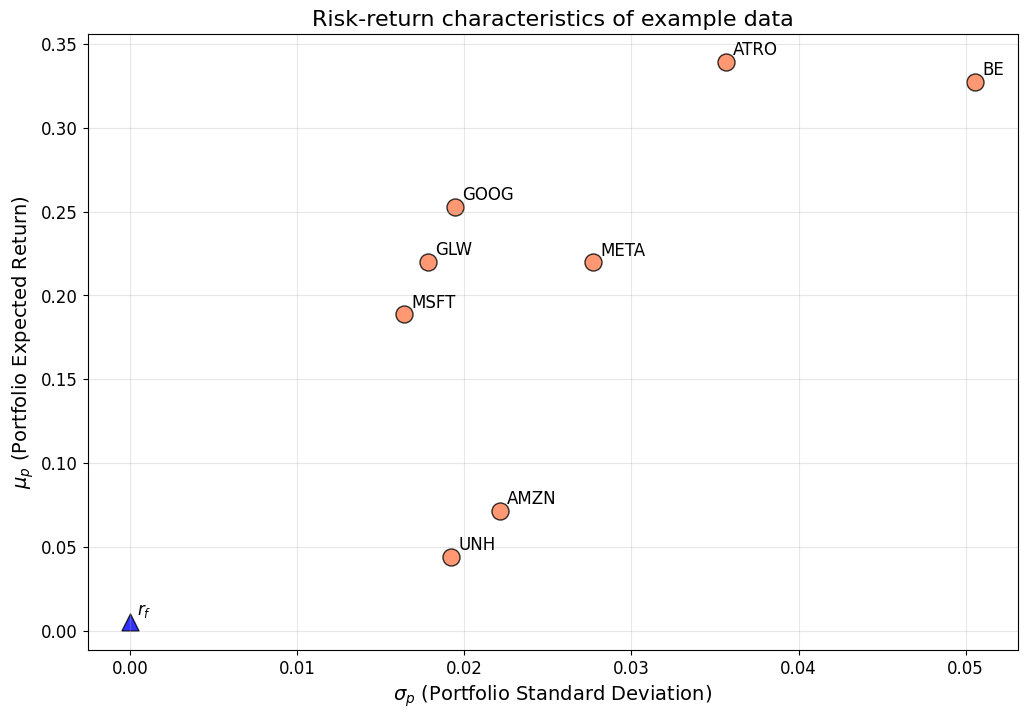

In [63]:
# Risk-return plot
sd_vec = np.sqrt(np.diag(sigma_mat))

plt.figure(figsize=(12, 8))
plt.scatter(sd_vec, mu_vec, s=150, c='coral', alpha=0.8, edgecolors='black')
plt.scatter(0, r_f, s=150, c='blue', alpha=0.8, marker='^', edgecolors='black')

# Add labels
for i, name in enumerate(asset_names):
    plt.annotate(name, (sd_vec[i], mu_vec[i]), xytext=(5, 5), textcoords='offset points', fontsize=12)
plt.annotate(r'$r_f$', (0, r_f), xytext=(5, 5), textcoords='offset points', fontsize=12)

plt.xlabel(r'$\sigma_p$ (Portfolio Standard Deviation)', fontsize=14)
plt.ylabel(r'$\mu_p$ (Portfolio Expected Return)', fontsize=14)
plt.title('Risk-return characteristics of example data', fontsize=16)
plt.grid(True, alpha=0.3)
plt.show()

## Portfolio Computations

### Equally Weighted Portfolio

In [64]:
# Consider an equally weighted portfolio for all assets
x_vec = np.ones(len(asset_names)) / len(asset_names)
x_df = pd.Series(x_vec, index=asset_names, name='Weights')

print("Equally weighted portfolio:")
print(x_df)
print(f"Sum of weights: {np.sum(x_vec)}")

# Portfolio return
mu_p_x = np.dot(x_vec, mu_vec)
print(f"\nPortfolio expected return: {mu_p_x:.4f}")

# Portfolio variance and standard deviation
sig2_p_x = x_vec.T @ sigma_mat @ x_vec
sig_p_x = np.sqrt(sig2_p_x)
# Annualize variance and standard deviation (assuming 252 trading days per year)

sig2_p_x_annual = sig2_p_x 
sig_p_x_annual = sig_p_x 

print(f"Portfolio variance (annualized): {sig2_p_x_annual:.6f}")
print(f"Portfolio standard deviation (annualized): {sig_p_x_annual:.4f}")

Equally weighted portfolio:
GOOG    0.125
GLW     0.125
MSFT    0.125
AMZN    0.125
META    0.125
UNH     0.125
BE      0.125
ATRO    0.125
Name: Weights, dtype: float64
Sum of weights: 1.0

Portfolio expected return: 0.2079
Portfolio variance (annualized): 0.000266
Portfolio standard deviation (annualized): 0.0163


### Alternative Portfolio with Different Weights

In [66]:

y_vec = np.array(
        [
            0.2,
            0.1,
            0.3,
            -0.2,
            0.4,
            0.2,
            0.3,
            -0.2,
            #-0.3,
            #0.1
        ]
    )
y_df = pd.Series(y_vec, index=asset_names, name='Weights')

print("Alternative portfolio:")
print(y_df)
print(f"Sum of weights: {np.sum(y_vec)}")

# Portfolio return, variance and standard deviation
mu_p_y = np.dot(y_vec, mu_vec)
sig2_p_y = y_vec.T @ sigma_mat @ y_vec
sig_p_y = np.sqrt(sig2_p_y)

print(f"\nPortfolio expected return: {mu_p_y * annual_factor:.4f}")
print(f"Portfolio variance (annualized): {sig2_p_y * annual_factor:.6f}")
print(f"Portfolio standard deviation (annualized): {sig_p_y * np.sqrt(annual_factor):.4f}")

# The covariance and correlation between the two portfolios
sig_xy = x_vec.T @ sigma_mat @ y_vec
rho_xy = sig_xy / (sig_p_x * sig_p_y)

print(f"\nCovariance between portfolios X and Y (annualized): {sig_xy * annual_factor:.6f}")
print(f"Correlation between portfolios X and Y: {rho_xy:.4f}")

Alternative portfolio:
GOOG    0.2
GLW     0.1
MSFT    0.3
AMZN   -0.2
META    0.4
UNH     0.2
BE      0.3
ATRO   -0.2
Name: Weights, dtype: float64
Sum of weights: 1.1

Portfolio expected return: 60.9977
Portfolio variance (annualized): 0.143018
Portfolio standard deviation (annualized): 0.3782

Covariance between portfolios X and Y (annualized): 0.078434
Correlation between portfolios X and Y: 0.8014


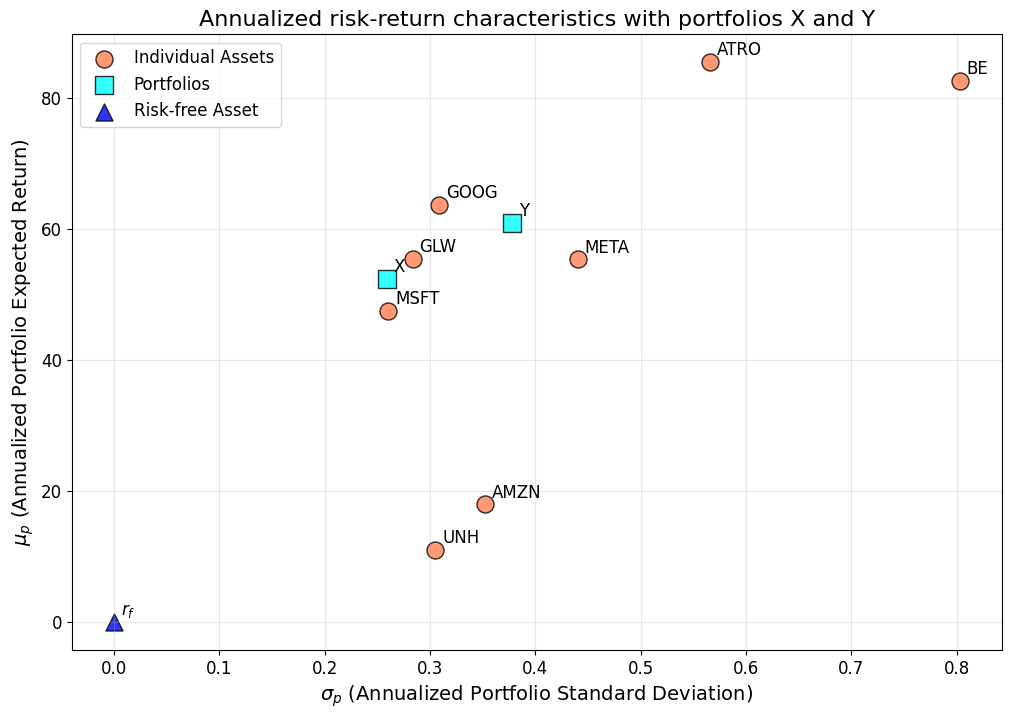

In [67]:
# Plot annualized return and risk characteristics with portfolios X and Y
plt.figure(figsize=(12, 8))
plt.scatter(sd_vec * np.sqrt(annual_factor), mu_vec * annual_factor, s=150, c='coral', alpha=0.8, edgecolors='black', label='Individual Assets')
plt.scatter([sig_p_x * np.sqrt(annual_factor), sig_p_y * np.sqrt(annual_factor)], 
            [mu_p_x * annual_factor, mu_p_y * annual_factor], 
            s=150, c='cyan', alpha=0.8, edgecolors='black', marker='s', label='Portfolios')
plt.scatter(0, r_f , s=150, c='blue', alpha=0.8, marker='^', edgecolors='black', label='Risk-free Asset')

# Add labels
for i, name in enumerate(asset_names):
    plt.annotate(name, (sd_vec[i] * np.sqrt(annual_factor), mu_vec[i] * annual_factor), xytext=(5, 5), textcoords='offset points', fontsize=12)
plt.annotate(r'$r_f$', (0, r_f), xytext=(5, 5), textcoords='offset points', fontsize=12)
plt.annotate('X', (sig_p_x * np.sqrt(annual_factor), mu_p_x * annual_factor), xytext=(5, 5), textcoords='offset points', fontsize=12)
plt.annotate('Y', (sig_p_y * np.sqrt(annual_factor), mu_p_y * annual_factor), xytext=(5, 5), textcoords='offset points', fontsize=12)

plt.xlabel(r'$\sigma_p$ (Annualized Portfolio Standard Deviation)', fontsize=14)
plt.ylabel(r'$\mu_p$ (Annualized Portfolio Expected Return)', fontsize=14)
plt.title('Annualized risk-return characteristics with portfolios X and Y', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Risk-return Characteristics of Random Portfolios

Generate a set of randomly generated three-asset portfolios whose weights sum to one

In [68]:
# Generate random portfolios
n = 1000
np.random.seed(61274)  # Set seed for reproducibility

# Generate random portfolios where weights sum to 1 for all assets
z_vec = np.zeros((n, len(asset_names)))
for i in range(n):
    weights = np.random.uniform(-0.1, 0.1, len(asset_names))
    weights /= np.sum(weights)
    z_vec[i, :] = weights

print("First 5 random portfolios:")
print(pd.DataFrame(z_vec[:5], columns=asset_names))
print(f"\nGenerated {n} random portfolios")

# Calculate portfolio returns and risks
mu_p_z = z_vec @ mu_vec
sig_p_z = np.sqrt(np.array([z_vec[i, :].T @ sigma_mat @ z_vec[i, :] for i in range(n)]))

print(f"Portfolio returns range: [{mu_p_z.min():.4f}, {mu_p_z.max():.4f}]")
print(f"Portfolio risks range: [{sig_p_z.min():.4f}, {sig_p_z.max():.4f}]")

First 5 random portfolios:
        GOOG        GLW      MSFT      AMZN      META       UNH        BE  \
0  -3.761748  -4.674845  3.249242 -1.047202  2.125168  3.693536 -2.992433   
1   0.113652   0.344722  0.318313  0.143070 -0.221515  0.420995  0.137750   
2 -11.401931  10.272731 -0.411267 -2.804179  5.598083  5.722601 -5.372742   
3   0.607066  -0.072874  0.880393 -0.481813 -0.707141 -0.387849  0.601174   
4   0.427708  -0.377674  0.241650  0.048671  0.414500 -0.289906  0.431151   

       ATRO  
0  4.408283  
1 -0.256986  
2 -0.603296  
3  0.561045  
4  0.103898  

Generated 1000 random portfolios
Portfolio returns range: [-121.1630, 40.8666]
Portfolio risks range: [0.0135, 47.9615]


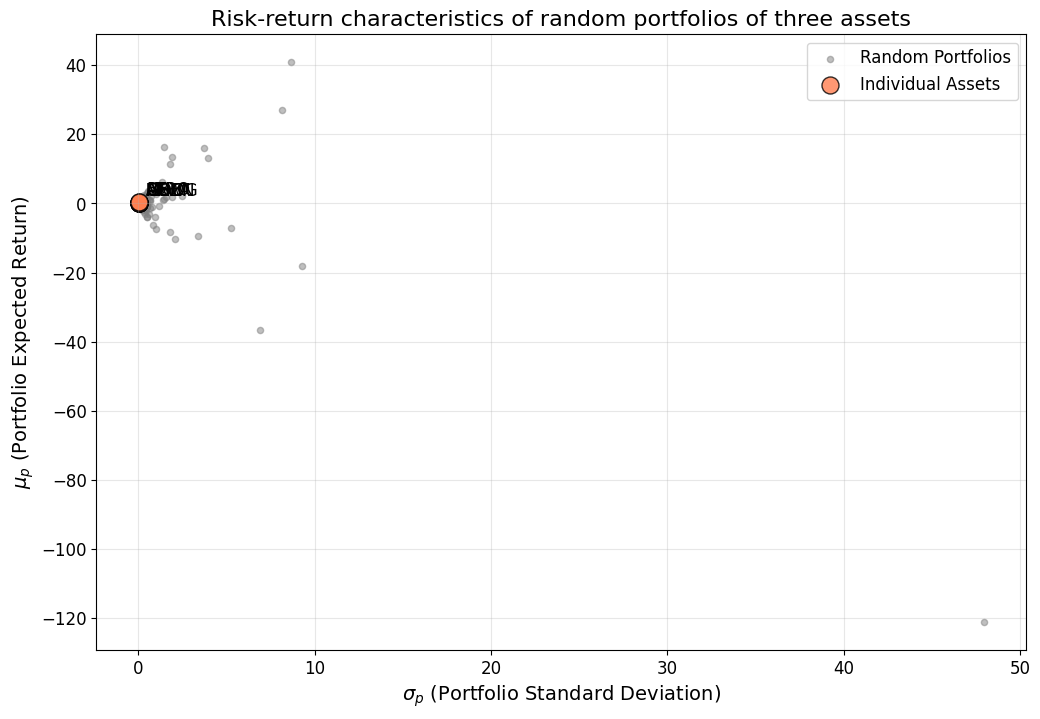

In [69]:
# Plot random portfolios
plt.figure(figsize=(12, 8))
plt.scatter(sig_p_z, mu_p_z, s=20, c='gray', alpha=0.5, label='Random Portfolios')
plt.scatter(sd_vec, mu_vec, s=150, c='coral', alpha=0.8, edgecolors='black', label='Individual Assets')

# Add labels for assets
for i, name in enumerate(asset_names):
    plt.annotate(name, (sd_vec[i], mu_vec[i]), xytext=(5, 5), textcoords='offset points', fontsize=12)

plt.xlabel(r'$\sigma_p$ (Portfolio Standard Deviation)', fontsize=14)
plt.ylabel(r'$\mu_p$ (Portfolio Expected Return)', fontsize=14)
plt.title('Risk-return characteristics of random portfolios of three assets', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Determining the Global Minimum Variance Portfolio (GMVP)

The Global Minimum Variance Portfolio is the portfolio with the lowest possible risk (variance) among all feasible portfolios.

In [70]:
# Calculate Global Minimum Variance Portfolio
ones = np.ones(len(asset_names))
w = solve(sigma_mat, ones)  # Solve sigma_mat * w = ones
m_vec = np.abs(w) / np.sum(np.abs(w))  # Normalize weights

# Create DataFrame for better visualization
gmvp_weights = pd.Series(m_vec, index=asset_names, name='GMVP Weights')
print("Global Minimum Variance Portfolio weights:")
print(gmvp_weights)
print(f"Sum of weights: {np.sum(m_vec):.6f}")

# Calculate GMVP characteristics
mu_gmin = m_vec.T @ mu_vec
sig2_gmin = m_vec.T @ sigma_mat @ m_vec
sig_gmin = np.sqrt(sig2_gmin)

print(f"\nGMVP expected return: {mu_gmin:.4f}")
print(f"GMVP variance: {sig2_gmin:.6f}")
print(f"GMVP standard deviation: {sig_gmin:.4f}")

Global Minimum Variance Portfolio weights:
GOOG    0.078954
GLW     0.272251
MSFT    0.289215
AMZN    0.004899
META    0.028651
UNH     0.284725
BE      0.019730
ATRO    0.021576
Name: GMVP Weights, dtype: float64
Sum of weights: 1.000000

GMVP expected return: 0.1673
GMVP variance: 0.000152
GMVP standard deviation: 0.0123


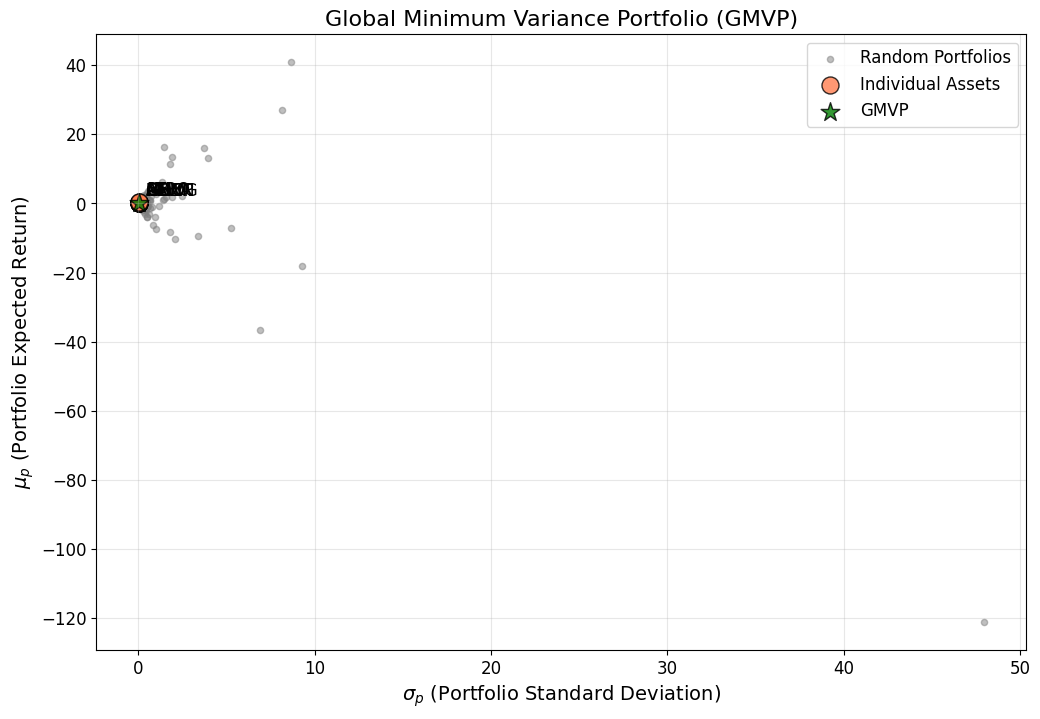

In [71]:
# Final plot with GMVP
plt.figure(figsize=(12, 8))
plt.scatter(sig_p_z, mu_p_z, s=20, c='gray', alpha=0.5, label='Random Portfolios')
plt.scatter(sd_vec, mu_vec, s=150, c='coral', alpha=0.8, edgecolors='black', label='Individual Assets')
plt.scatter(sig_gmin, mu_gmin, s=200, c='green', alpha=0.8, edgecolors='black', 
           marker='*', label='GMVP')

# Add labels
for i, name in enumerate(asset_names):
    plt.annotate(name, (sd_vec[i], mu_vec[i]), xytext=(5, 5), textcoords='offset points', fontsize=12)
plt.annotate('GMVP', (sig_gmin, mu_gmin), xytext=(5, 5), textcoords='offset points', fontsize=12)

plt.xlabel(r'$\sigma_p$ (Portfolio Standard Deviation)', fontsize=14)
plt.ylabel(r'$\mu_p$ (Portfolio Expected Return)', fontsize=14)
plt.title('Global Minimum Variance Portfolio (GMVP)', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Summary

This notebook demonstrated key concepts in portfolio theory using matrix algebra:

1. **Individual Asset Characteristics**: We analyzed the risk-return profile of three assets (MSFT, NORD, SBUX)
2. **Portfolio Construction**: We computed portfolio returns and risks for different weight combinations
3. **Random Portfolio Analysis**: We generated 1000 random portfolios to visualize the feasible portfolio space
4. **Global Minimum Variance Portfolio**: We mathematically derived the portfolio with the lowest possible risk

The GMVP represents an important benchmark in portfolio theory as it provides the minimum risk achievable through diversification, regardless of expected returns.